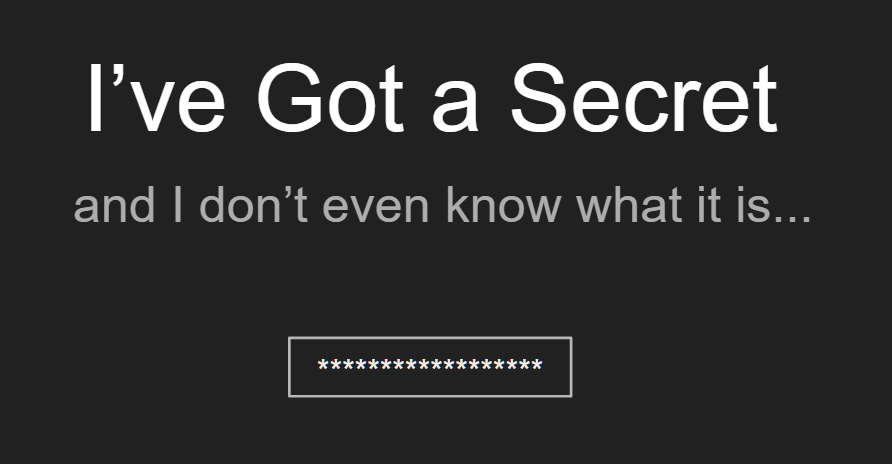

# Welcome to this workshop on application configuration with .NET Core, Azure and Azure DevOps!

### Keeping secrets out of source code has always been challenging. De-coupling sensitive information like connection strings, certificates and passwords from your development projects means you won't have accidental exposure. .Net Core now provides a rich configuration system that goes far beyond the legacy web.config appSettings. This is great for development and debugging, but how do we manage configuration when it is time to go to production? In this hands-on workshop we will first configure a local application to pull configuration from various sources and then we will move on to explore real world production deployment scenarios.

This workshop will guide you through step-by-step exercises including:

* Working with Azure App Services configuration and environment variables.
* How to leverage Managed Identities for Azure Resources to eliminate a whole class of stored secrets.
* Configure KeyVaults and Access Policies and integrate them with DevOps.
* Setting up Azure DevOps build and release pipelines and experimenting with Tasks and Variables to configure applications for production.
* Connecting Azure DevOps to Azure App Service Deployments.
* Slot deployments and maintaining different configuration versions between them.
* Configuring and obtaining secrets from pipeline Variables, shared Library Variable Groups and Secure Files.
* Transforming json configuration files during release pipelines.

# Prerequisites

#### This workshop has been designed to be as flexible as possible. Whether on Windows, Mac or Linux, you will be able to complete this workshop with the following tools:

* [.NET Core SDK](https://dotnet.microsoft.com/download/dotnet-core/3.1). If you are using full Visual Studio 2019 just make sure it has the latest update. If you are not already setup for .NET Core development, download and install the SDK, not just the runtime.
* An Azure account. [The free trial](https://azure.microsoft.com/en-us/free/) is more than sufficient for this course.
* Setup an Azure DevOps project. Use [the quickstart guide](https://docs.microsoft.com/en-us/azure/devops/user-guide/sign-up-invite-teammates?view=azure-devops) to create your account and setup a "Project". You will not need to invite team members or configure invitations.
* Azure CLI access. You can [install the Azure CLI](https://docs.microsoft.com/en-us/cli/azure/install-azure-cli?view=azure-cli-latest) locally, or if you prefer, you can perform all Azure CLI operations from the [Azure Cloud Shell](https://shell.azure.com) which runs entirely in the browser. 
* [Powershell or Powershell Core](https://docs.microsoft.com/en-us/powershell/azure/install-az-ps?view=azps-3.0.0) (which has its own requirements). Once you have this installed, you can execute Powershell commands right from this notebook.
* A Github account, or if you are comfortable doing your own thing, any Azure-supported repository will work. This workshop will use Github as the source code reposity so you will be on your own if you choose to use something else.
* Get the application we will be working with and make sure it runs. Exercise #1 provides an overview of the sample application. For now, just acquire it and test it.
 * Clone the repository (https://github.com/crowcoder/IHaveASecret.git)
 * Run with debugging in VS Code. Tip, use the debug charm: 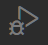 (ctrl+shift+d on windows)
 * Use your favorite HTTP client (Browser, Postman, Fiddler, Powershell) and navigate to https://localhost:5001/Configuration. You should receive the folowing  JSON:
  * `["Test -  Hello World!"]`
  * Optionally, make a request to your API right here! Just highlight the next cell and press the run toolbar button (give it a moment to run, there is no progress indicator):



In [2]:
$api = "https://localhost:5001/Configuration" #this and all variables are available throughout this notebook. Feel free to make any additions you like to any script.
Invoke-WebRequest -URI $api


StatusCode        : 200
StatusDescription : OK
Content           : ["Test - Hello World!","I came from appsettings."]
RawContent        : HTTP/1.1 200 OK
                    Date: Sat, 11 Apr 2020 15:11:40 GMT
                    Server: Kestrel
                    Transfer-Encoding: chunked
                    Content-Type: application/json; charset=utf-8
                    
                    ["Test - Hello World!","I came from appsettings."]
Headers           : {[Date, System.String[]], [Server, System.String[]], [Transfer-Encoding, 
                    System.String[]], [Content-Type, System.String[]]}
Images            : {}
InputFields       : {}
Links             : {}
RawContentLength  : 50
RelationLink      : {}




***Optional***
* The new **Windows Terminal**. Avaiable in the Windows Store (for free). With this terminal you can utilize multiple tabs, each with it's own shell - Powershell, cmd or Cloud Shell.
* [Visual Studio Code](https://code.visualstudio.com/). While any text editor will work, VS Code is a great, free editor that integrates nicely with .NET and Powershell. If you do use VS Code, you will also need the C# extension: [C# for Visual Studio Code (powered by OmniSharp).](https://marketplace.visualstudio.com/items?itemName=ms-dotnettools.csharp). Of course you can also use full Visual Studio, Rider or even notepad. 
* Familiarize yourself with the basics of Jupyter notebooks. This is an interactive document. You can add your own notes and scripts. Feel free to experiment.

# Exercise #1, Exploring the sample application (15 min.)

The IGAS (I've Got a Secret) application is a ASP.NET API. There are no web pages, just a single endpoint that returns JSON. The code and structure of the application is kept as simple as possible to concentrate on how to use configuration settings as opposed to how to create an API in .NET Core. The JSON payload is simply going to reflect configuration values so we can observe the behavior as we edit the application.

If you are familiar with the `dotnet` cli, you might notice the source code differs from what you get when you create a new application: `dotnet new webapi`. The difference is intentional - some of what is normally abstracted has been explicitly written for educational purposes.

### A little bit about .NET Core Configuration
.NET Core is a major overhaul to the configuration system previously used by .NET Framework applications. When I say "configuration", I'm talking about data that cannot or is not practical to be set at development time. Commonly configured values include URL's, file paths, passwords, etc. - things that have test values during debugging but production values when running live. It has often been a challenge to store configuration such that it is not exposed. .NET Core provides various ways to keep these potentially sensitive values out of source control repositories.

> [More Information on .NET Core Configuration](https://docs.microsoft.com/en-us/aspnet/core/fundamentals/configuration/?view=aspnetcore-3.1)

In .NET Core, configuration can come from nearly any conceivable source, know as Providers. - JSON, XML and INI files, Azure Keyvault, command line arguments, environment variables, User Secrets, and the list goes on. You can even implement your own configuration provider if none of the existing ones meet your needs.

Let's begin exploring configuration by adding a setting to the JSON file in the sample project.

Open up `appsettings.Development.json` and add a new string entry: `"FromAppSettings" :"I came from appsettings."`
The entire file should look like this when you are done:

```
    {
      "Logging": {
        "LogLevel": {
          "Default": "Information",
          "Microsoft": "Warning",
          "Microsoft.Hosting.Lifetime": "Information"
        }
      },
      "FromAppSettings" :"I came from appsettings."
    }
```
Next, edit the controller to return this configuration value.
1. In the Controllers folder, open the file `ConfigurationController.cs`.
2. Edit the `Get()` action to return the new configuration setting in adddition to the Test value:

```
    [HttpGet]
    public IEnumerable<string> Get()
    {
        string appSettingValue =_config.GetValue<string>("FromAppSettings") ?? "NOT SET";
        
        return new string[] { 
            "Test - Hello World!",
            appSettingValue
         };
    }
```
3. Run the application and invoke a GET request to the controller just like you did in the prerequisites. Since this notebook is interactive, you go back and execute that code again, but here it is for convenience:


In [6]:
Invoke-WebRequest -URI $api


StatusCode        : 200
StatusDescription : OK
Content           : ["Test - Hello World!","I'm actually from the command line argument"]
RawContent        : HTTP/1.1 200 OK
                    Date: Sat, 11 Apr 2020 15:43:42 GMT
                    Server: Kestrel
                    Transfer-Encoding: chunked
                    Content-Type: application/json; charset=utf-8
                    
                    ["Test - Hello World!","I'm actually from the comman…
Headers           : {[Date, System.String[]], [Server, System.String[]], [Transfer-Encoding, 
                    System.String[]], [Content-Type, System.String[]]}
Images            : {}
InputFields       : {}
Links             : {}
RawContentLength  : 69
RelationLink      : {}




You should now see the new configuration value in the body of the response:

`["Test - Hello World!","I came from appsettings."]`

> OK, but what happened and what makes that work?

Let's dive a little deeper in the Configuration Providers. This material provides the base of understanding for all the work we will do from here on out, including Azure.

In the root of the project, there is `Program.cs`. If you think this file looks like a console application, that's because it is. .NET Core applications are console applications that happen to get hosted by something like Internet Information Services. The following code is executed at startup, we mostly just care about the numbered lines. Please note that this code is an edited version of the ASP .NET Core source code. The default project template abstracts this away but it is valuable for demonstration:

```
        public static IWebHostBuilder CreateDefaultBuilderManually(string[] args)
        {
            var builder = new WebHostBuilder();

            builder.UseContentRoot(Directory.GetCurrentDirectory());

            if (args != null)
            {
1.               builder.UseConfiguration(new ConfigurationBuilder().AddCommandLine(args).Build());
            }

            builder.ConfigureAppConfiguration((hostingContext, config) =>
            {
                var env = hostingContext.HostingEnvironment;

2.               config.AddJsonFile("appsettings.json", optional: true, reloadOnChange: true)
3.                     .AddJsonFile($"appsettings.{env.EnvironmentName}.json", optional: true, reloadOnChange: true);

                if (env.IsDevelopment())
                {
                    var appAssembly = Assembly.Load(new AssemblyName(env.ApplicationName));
                    if (appAssembly != null)
                    {
4.                      config.AddUserSecrets(appAssembly, optional: true);
                    }
                }

5.              config.AddEnvironmentVariables();

                if (args != null)
                {
6.                  config.AddCommandLine(args);
                }
            })
            .ConfigureLogging((hostingContext, logging) =>
            {
                logging.AddConfiguration(hostingContext.Configuration.GetSection("Logging"));
                logging.AddConsole();
                logging.AddDebug();
                logging.AddEventSourceLogger();
            }).
            UseDefaultServiceProvider((context, options) =>
            {
                options.ValidateScopes = context.HostingEnvironment.IsDevelopment();
            });

            ConfigureWebDefaultsManually(builder);

            return builder;
        }
```

Much of this code is not important in the context of what we are learning about configuration but I have numbered the relevant lines. 
Notice this "thing" called **config**. Think of this as the configuration system for .NET Core. Looking at lines 2 and 3, we see `AddJsonFile`. This code instructs the runtime to go read the contents of these files and pull the information into the overall configuration environment. With that happening on start up, we can explain the code we wrote in the controller:

`string appSettingValue =_config.GetValue<string>("FromAppSettings") ?? "NOT SET";`

Again, `_config` represents the .NET Core configuration system. We are asking it to get a value from configuration with the key "FromAppSettings". If it is not found then use the value "NOT SET".

The important thing to notice here is that we do not write code that says "get the value of FromAppSettings from the appsettings.Development.json file". We just ask `_config` to get the value **regardles of what configuration provider injested it**.

To drive that point home let's demonstrate that concept and another. The other is how configuration providers override eachother. In other words, order matters. As the code execution progresses from line 1, to 2 to 3 etc., the various providers will override any previously injested values by the same name.

To demonstrate, lets run the application an pass it a command line variable that has the same key as the value we added to appSettings.Development.json.

Open a terminal to the root of the project and invoke the dotnet cli command to build and run the application, including a command line parameter by the same name as the one we already used, but with a different value so we can observe the behavior.

`dotnet run --FromAppSettings "I'm actually from the command line argument"`

Wait for it to start up and then invoke the GET request:


In [ ]:
Invoke-WebRequest -URI $api

Notice how the command line argument overrode the appSetting? That is because, in startup, `config.AddCommandLine(args);` is called after `config.AddJson(...`. 

We have just learned how the configuration system injests settings from various sources and bundles them up in one "location". This is a very powerful techinque to use. It allows us to put configuration anywhere we want during development without needing to have the same configuration provider being used in production. For example, you can put a URL in a json file, but in production you can put it in an environment variable and your code does not have to change.

We have also just learned the first example of providing configuration without storing it where it would be accidentally checked in to source control. While I personally have not had much use for passing command line arguments to .NET Core applications, it is definitely an option and it does not require persistence in any project file.
